In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import utils

import xgboost as xgb
from sklearn.metrics import mean_squared_error
plt.style.use('fivethirtyeight')

color_pal = sns.color_palette()

plt.rcParams['lines.linewidth']=1         #changing default linewidth
plt.rcParams['lines.markersize']=5        #changinf default markersize

In [2]:
root_dir = 'C:\\Users\\Sambuddha\\Downloads\\'
target_test_cutoff_date = '01-01-2016'      #splitting will be done using this date as reference

In [3]:
df = pd.read_csv(root_dir+'PJME_hourly.csv')       #reading file
df = df.set_index('Datetime')                  #set index name as Datetime
df.index = pd.to_datetime(df.index)       #convert the values into date and time format

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145366 entries, 2002-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   PJME_MW  145366 non-null  float64
dtypes: float64(1)
memory usage: 2.2 MB


In [5]:
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [6]:
df.tail()

,PJME_MW
Datetime,
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0
2018-01-01 23:00:00,40164.0
2018-01-02 00:00:00,38608.0


In [7]:
df.index

DatetimeIndex(['2002-12-31 01:00:00', '2002-12-31 02:00:00',
               '2002-12-31 03:00:00', '2002-12-31 04:00:00',
               '2002-12-31 05:00:00', '2002-12-31 06:00:00',
               '2002-12-31 07:00:00', '2002-12-31 08:00:00',
               '2002-12-31 09:00:00', '2002-12-31 10:00:00',
               ...
               '2018-01-01 15:00:00', '2018-01-01 16:00:00',
               '2018-01-01 17:00:00', '2018-01-01 18:00:00',
               '2018-01-01 19:00:00', '2018-01-01 20:00:00',
               '2018-01-01 21:00:00', '2018-01-01 22:00:00',
               '2018-01-01 23:00:00', '2018-01-02 00:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=145366, freq=None)

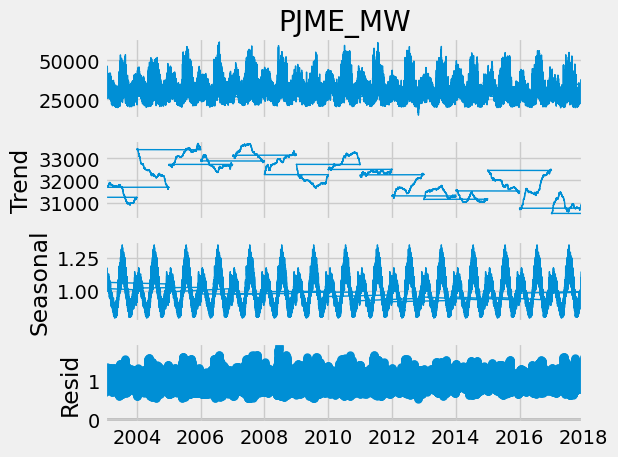

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose

ANNUAL_PERIOD = 365*24      #number of hours in a year
multi_decomp = seasonal_decompose(df['PJME_MW'], model = 'multiplicative', extrapolate_trend = 'freq', period = ANNUAL_PERIOD)    #using multiplicative model (Y = T*S*R), extrapolate trend using specified frequency, time period is number of hours in a year
multi_decomp.plot()
plt.show()

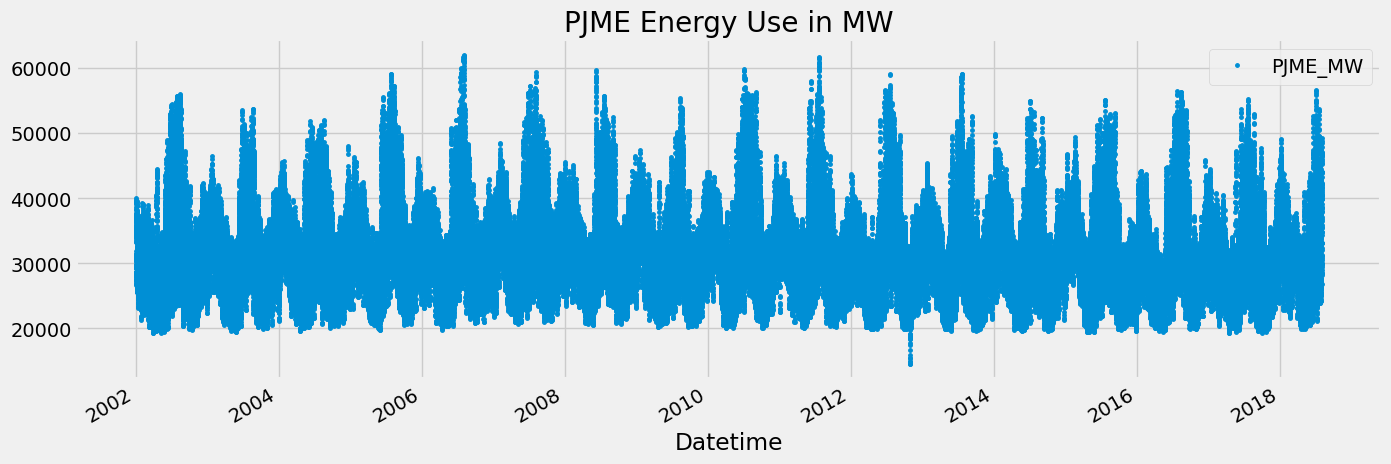

In [9]:
df.plot(style = '.',
        figsize = (15,5),
        color = color_pal[0],
        title = 'PJME Energy Use in MW')
plt.show()

In [10]:
#splitting into train and test sets
train = df.loc[df.index < target_test_cutoff_date]
test = df.loc[df.index >= target_test_cutoff_date]

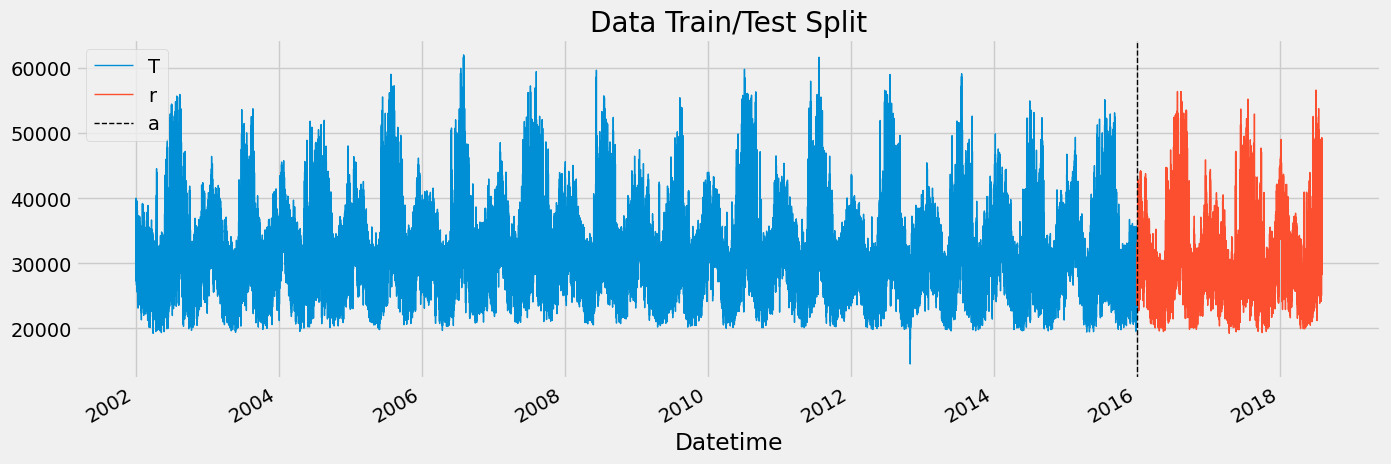

In [11]:
utils.plot_train_test_split(df, target_test_cutoff_date)      #plotting the split

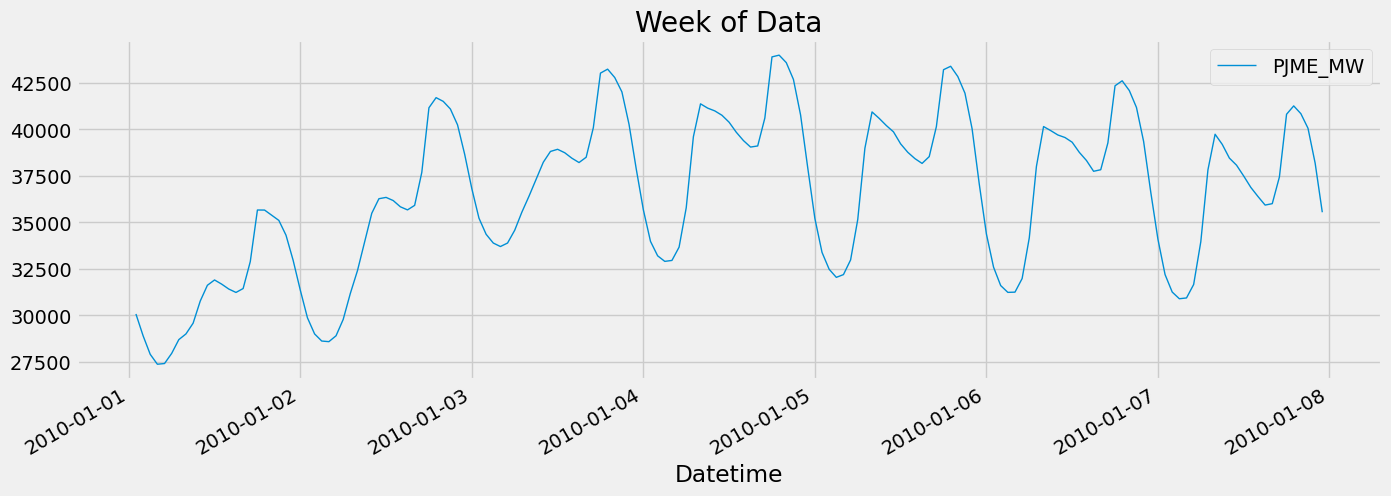

In [12]:
utils.plot_week_of_data(df, '01-01-2010', '01-08-2010')

In [13]:
df = utils.create_time_series_features(df)

In [14]:
df.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365,31,1
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365,31,1
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365,31,1
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365,31,1
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365,31,1


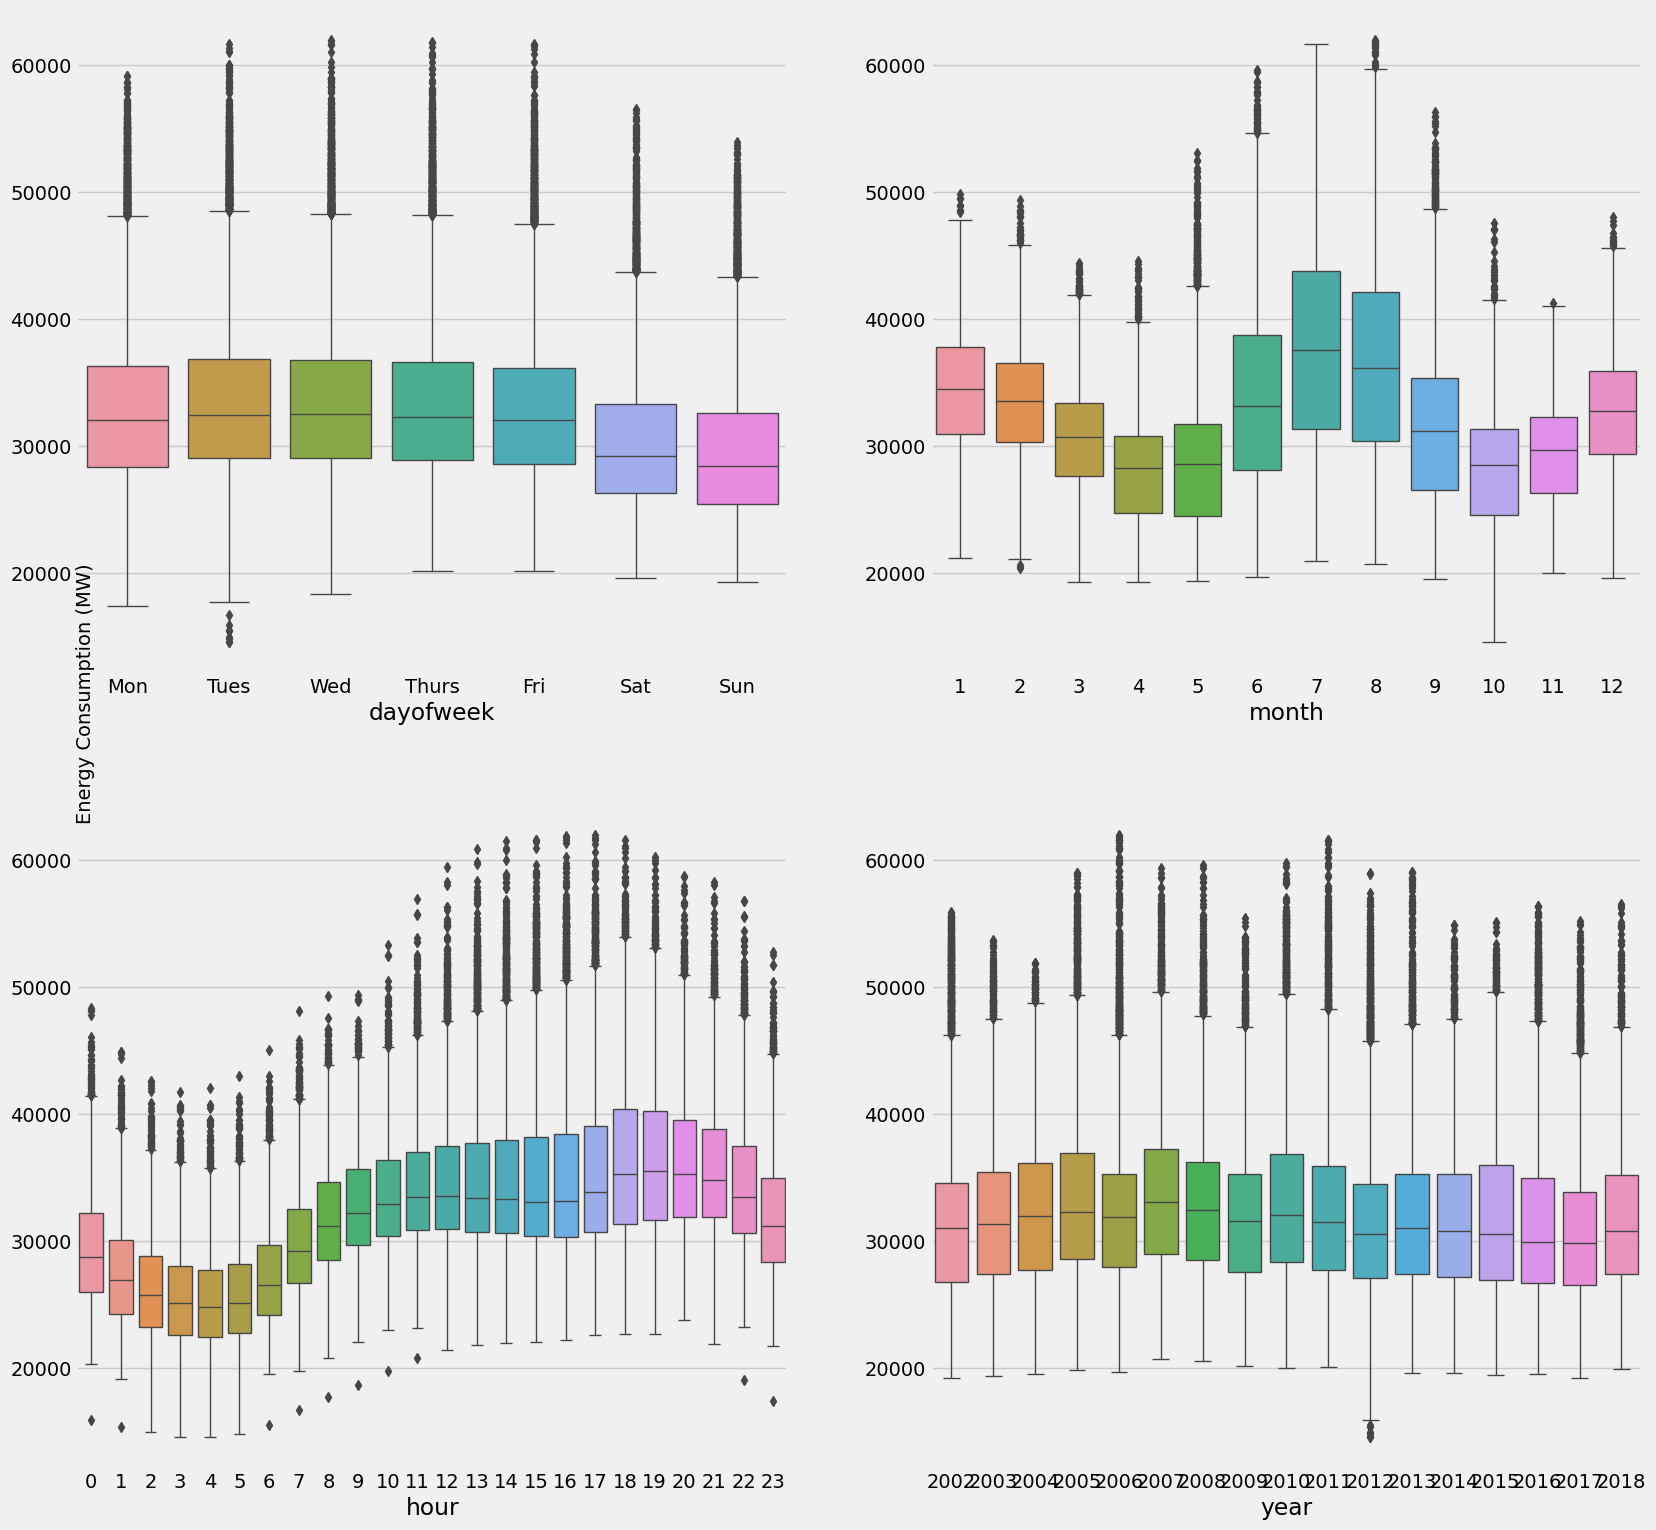

In [15]:
def plot_time_series(df, dependent_var):
    """
    Generates a 2x2 grid of boxplots to visualise the time series data

    Args:
      df (Pandas.dataframe): DataFrame containing time series data
      dependent_var (string): column name of the dependent variable in the dataset
    Returns:
      None
    """
    assert 'dayofweek' in df.columns, "Input dataframe must have a 'dayofweek' column"
    assert 'month' in df.columns, "Input dataframe must have a 'month' column"
    assert 'hour' in df.columns, "Input dataframe must have an 'hour' column"
    assert 'year' in df.columns, "Input dataframe must have a 'year' column"
    assert dependent_var in df.columns, f"Input dataframe must have a '{dependent_var}' column"

    # Initialising figure with 2x2 grid
    fig, axes = plt.subplots(2, 2, figsize=(18,18))

    # Day of Week
    dow_labels = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
    g = sns.boxplot(x=df.dayofweek, y=df[dependent_var], ax=axes[0][0])
    g.set_xticklabels(dow_labels)
    g.set_ylabel('')

    # Month of Year
    g = sns.boxplot(x=df.month, y=df[dependent_var], ax=axes[0][1])
    g.set_ylabel('')

    # Hour of Day
    g = sns.boxplot(x=df.hour, y=df[dependent_var], ax=axes[1][0])
    g.set_ylabel('')

    # Year
    g = sns.boxplot(x=df.year, y=df[dependent_var], ax=axes[1][1])
    g.set_ylabel('')

    fig.text(0.08, 0.5, 'Energy Consumption (MW)', va='center', rotation='vertical')

    plt.show()

plot_time_series(df, 'PJME_MW')

In [16]:
df_dup = df.copy()
years_months = df_dup.groupby(['year', 'month']).mean().reset_index()
years_months.head()

,year,month,PJME_MW,hour,dayofweek,quarter,dayofyear,dayofmonth,weekofyear
0,2002,1,31075.399731,11.515478,2.905787,1.0,16.020188,16.020188,2.873486
1,2002,2,30239.166667,11.500000,3.000000,1.0,45.500000,14.500000,7.071429
2,2002,3,28875.256720,11.500000,3.193548,1.0,75.000000,16.000000,11.258065
3,2002,4,28534.731572,11.511822,2.828929,2.0,105.511822,15.511822,15.668985
4,2002,5,28073.653226,11.500000,3.000000,2.0,136.000000,16.000000,20.0


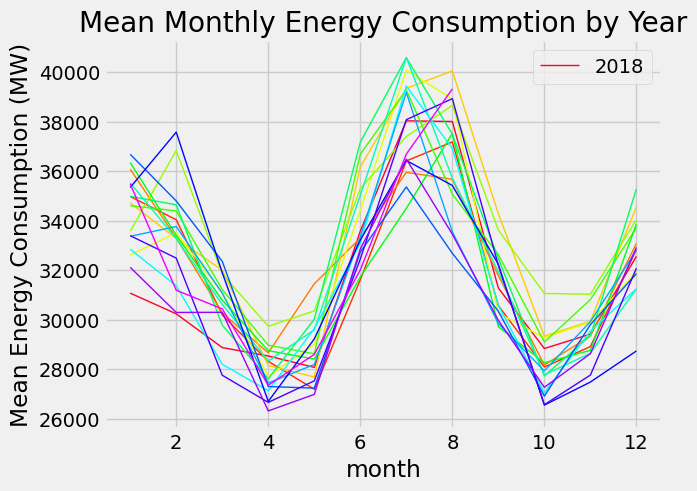

In [17]:
def plot_monthly_consumption(df, dependent_var):
    """
    Function generates line plot of mean energy consumption for each year

    Args:
      df (pd.DataFrame): DataFrame containing time series data
      dependent_var (string): Columns name of dependent variable in the DataFrame

    Returns:
      None
    """
    assert 'year' in df.columns, "Input dataframe must have a 'year' column"
    assert 'month' in df.columns, "Input dataframe must have a 'month' column"
    assert dependent_var in df.columns, f"Input dataframe must have a '{dependent_var}' column"
    df_copy = df.copy()
    year_group = df_copy.groupby(['year', 'month']).mean().reset_index()

    years = df_copy['year'].unique()
    NUM_COLOURS = len(years)

    cm = plt.get_cmap('gist_rainbow')
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_prop_cycle(color=[cm(1.*i/NUM_COLOURS) for i in range(NUM_COLOURS)])

    for i,y in enumerate(years):
        df_copy = year_group[year_group['year']==y]
        plt.plot(df_copy['month'], df_copy[dependent_var], linewidth=1, markersize=5)

    plt.title('Mean Monthly Energy Consumption by Year')
    plt.xlabel('month')
    plt.ylabel('Mean Energy Consumption (MW)')
    plt.legend(df_copy.year.unique())
    plt.show()
plot_monthly_consumption(df, 'PJME_MW')

In [18]:
train.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [19]:
train = utils.create_time_series_features(train)
test = utils.create_time_series_features(test)

In [20]:
train.head(2)

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365,31,1
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365,31,1


In [21]:
train['weekofyear'] = train['weekofyear'].astype('int32')
test['weekofyear'] = test['weekofyear'].astype('int32')

In [22]:
time_series_features = ['dayofyear', 'hour', 'dayofweek', 'weekofyear', 'quarter', 'month', 'year']
time_series_target = 'PJME_MW'

X_train = train[time_series_features]
y_train = train[time_series_target]

X_test = test[time_series_features]
y_test = test[time_series_target]

In [23]:
X_train.head(2)

,dayofyear,hour,dayofweek,weekofyear,quarter,month,year
Datetime,,,,,,,
2002-12-31 01:00:00,365,1,1,1,4,12,2002
2002-12-31 02:00:00,365,2,1,1,4,12,2002


In [24]:
y_test.head(2)

Datetime
2016-01-01 00:00:00    26686.0
2016-12-31 01:00:00    29627.0
Name: PJME_MW, dtype: float64

In [25]:
model = utils.train_xgb_regressor(X_train, y_train, X_test, y_test, use_gpu=True)

[0]	validation_0-rmse:32564.22910	validation_1-rmse:31495.85772
[100]	validation_0-rmse:12393.67251	validation_1-rmse:11543.16771
[200]	validation_0-rmse:5415.46199	validation_1-rmse:5205.16769
[300]	validation_0-rmse:3374.13737	validation_1-rmse:3975.14901
[400]	validation_0-rmse:2889.17236	validation_1-rmse:3934.67814
[412]	validation_0-rmse:2861.28937	validation_1-rmse:3944.70044


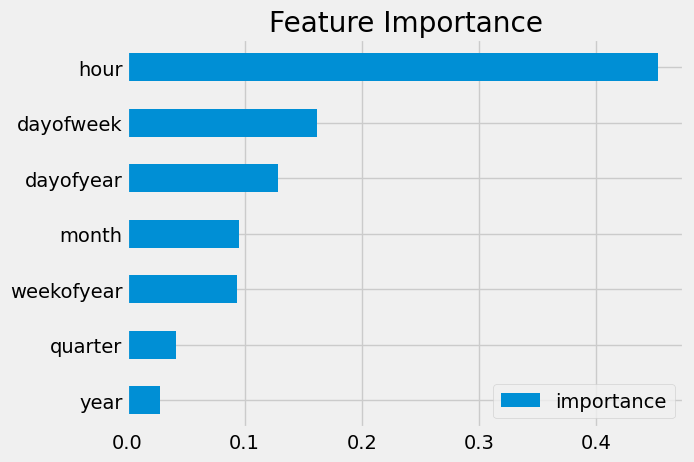

In [26]:
utils.plot_feature_importance(model)

In [27]:
test['prediction'] = model.predict(X_test)

df = df.merge(test[['prediction']], how = 'left', left_index = True, right_index = True)

df.tail(2)

c:\Users\Sambuddha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [18:04:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,prediction
Datetime,,,,,,,,,,
2018-08-02 23:00:00,38500.0,23,3,3,8,2018,214,2,31,36573.000000
2018-08-03 00:00:00,35486.0,0,4,3,8,2018,215,3,31,32774.132812


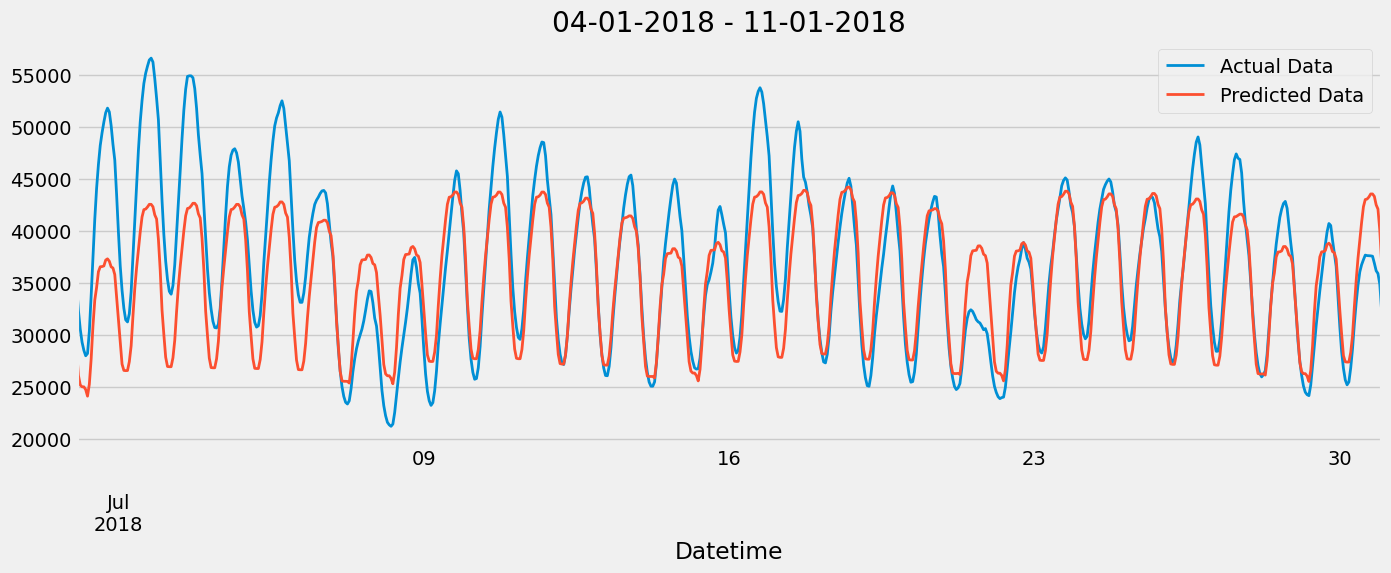

In [28]:
#select data within a specified date range
data = df.loc[(df.index > '07-01-2018') & (df.index < '07-31-2018')]

#plotting the data
ax = data['PJME_MW'].plot(figsize=(15,5), title='04-01-2018 - 11-01-2018', linewidth=2, markersize=5)

data['prediction'].plot(style='-', linewidth=2, markersize=5)

plt.legend(['Actual Data', 'Predicted Data'])
plt.show()

In [29]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE Score on Test Set: {score: 0.2f}')

RMSE Score on Test Set:  3916.46


In [30]:
test['error'] = np.abs(test[time_series_target] - test['prediction'])

test['date'] = test.index.date

test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2016-08-13    13209.418213
2016-08-14    12569.392008
2017-12-31    12090.446533
2016-09-10    11552.856201
2017-12-28    11538.608073
2017-12-29    11430.157796
2018-01-06    10922.202148
2016-08-12    10699.808757
2016-12-16    10695.838786
2018-01-07    10386.012939
Name: error, dtype: float64